## 1) Importation des bibliothèques et du fichier CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import spacy

import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [2]:
# Chargement du dataset avec bon encodage
df = pd.read_csv("rapport_maintenance_synthetique.csv", encoding="utf-8-sig")
df.head()

,date,technicien,site,equipement,rapport,type_anomalie,panne_critique
0,2025-01-18,Julie Muller,Site hybride de Montpellier,Date/heure,Erreur de conversion de date ISO8601.,logiciel,0
1,2025-01-08,Samir Morel,Parc éolien d’Amiens,capteur irradiance,Valeurs nulles enregistrées sur le capteur irr...,capteur,1
2,2024-11-28,Alex Blanc,Site éolien de Reims,soudure / joints,Fragilité de l’assemblage soudé sur un élément...,structurelle,1
3,2024-06-28,Jordan Bernard,Unité solaire d’Avignon,Charge / Impédance,Résistance de charge anormalement élevée.,électrique,0
4,2024-06-08,Antoine Muller,Unité solaire d’Avignon,Endpoints/API,La réponse JSON ne correspond pas au schéma at...,logiciel,0


## 2) Prétraitement NLP de la colonne rapport

In [3]:
# Charger le modèle français large
nlp = spacy.load("fr_core_news_lg")

# Stop words issus de SpaCy (cohérents avec lemmes)
stop_words = nlp.Defaults.stop_words

def nettoyer_texte(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # suppression des chiffres
    text = text.translate(str.maketrans('', '', string.punctuation))  # suppression ponctuation

    # Traitement NLP complet
    doc = nlp(text)

    # Lemmatization + suppression des stop words + nettoyage
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in stop_words and not token.is_space and token.is_alpha
    ]

    return " ".join(tokens)

# Application sur DataFrame
df["rapport_clean"] = df["rapport"].astype(str).apply(nettoyer_texte)

In [4]:
df[["rapport","rapport_clean"]].head(10)

,rapport,rapport_clean
0,Erreur de conversion de date ISO8601.,erreur conversion date iso
1,Valeurs nulles enregistrées sur le capteur irr...,valeur enregistrer capteur irradiance
2,Fragilité de l’assemblage soudé sur un élément...,fragilité assemblage souder élément transversal
3,Résistance de charge anormalement élevée.,résistance charge anormalement élevé
4,La réponse JSON ne correspond pas au schéma at...,réponse json correspondre schéma attendre
5,Le profil en L présente un renflement anormal.,profil l présente renflement anormal
6,Surintensité déclenchée par le disjoncteur.,surintensité déclencher disjoncteur
7,Niveau de signal électrique instable mesuré.,niveau signal électrique instable mesurer
8,Corrosion structurelle favorisée par un enviro...,corrosion structurel favoriser environnement h...
9,Saturation du capteur de courant.,saturation capteur courant


## 3) Visualisations exploratoires

#### a. Répartition des classes panne_critique

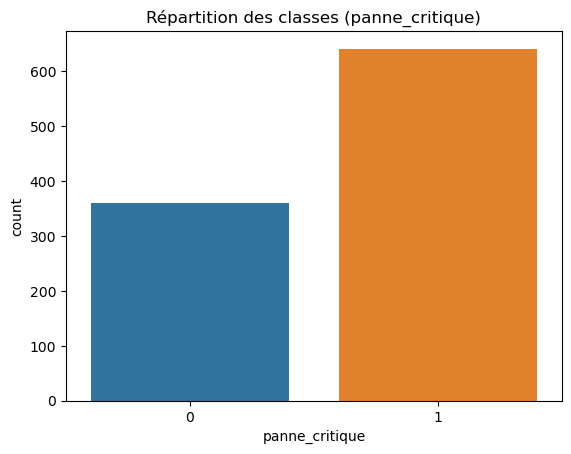

In [5]:
sns.countplot(data=df, x="panne_critique")
plt.title("Répartition des classes (panne_critique)")
plt.show()

#### b. Nuage de mots par classe

In [6]:
from wordcloud import WordCloud

text_critique = " ".join(df[df["panne_critique"] == 1]["rapport_clean"])
text_non_critique = " ".join(df[df["panne_critique"] == 0]["rapport_clean"])

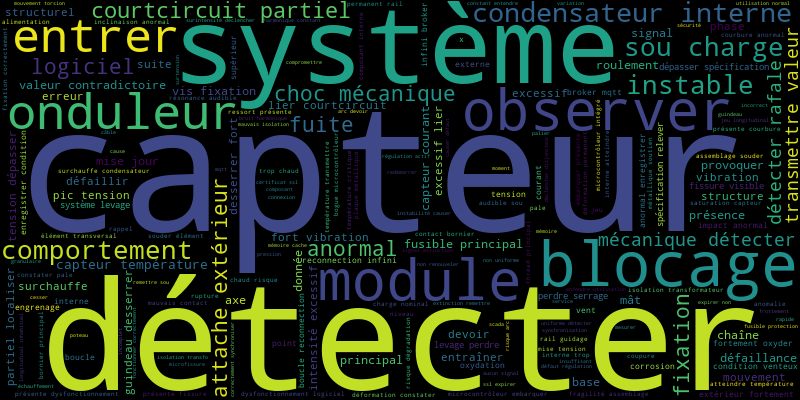

In [7]:
# text critique
WordCloud(width=800, height=400).generate(text_critique).to_image()

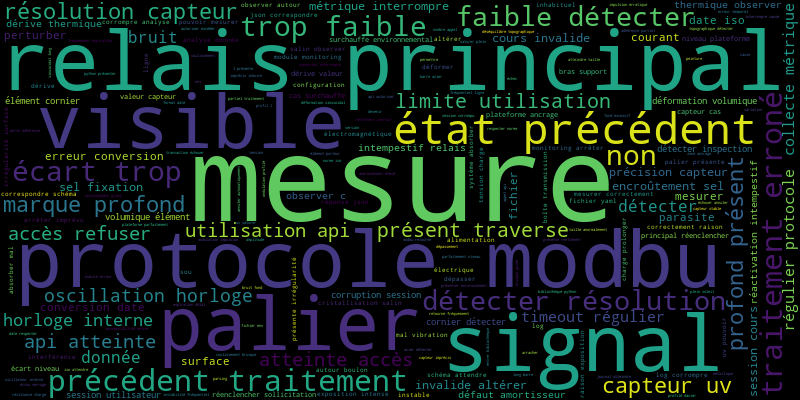

In [8]:
# text non critique
WordCloud(width=800, height=400).generate(text_non_critique).to_image()

## 4) Vectorisation TF-IDF

In [9]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_text = vectorizer.fit_transform(df["rapport_clean"])

# Cible
y = df["panne_critique"]

## 5) Modélisation (Régression logistique)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilité d'être critique
y_pred = model.predict(X_test)

## 6) Évaluation du modèle

In [11]:
print("Classification Report :\n", classification_report(y_test, y_pred))
print("AUC :", roc_auc_score(y_test, y_proba))

Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        78
           1       0.87      1.00      0.93       122

    accuracy                           0.91       200
   macro avg       0.94      0.88      0.90       200
weighted avg       0.92      0.91      0.91       200

AUC : 0.9736233711643547


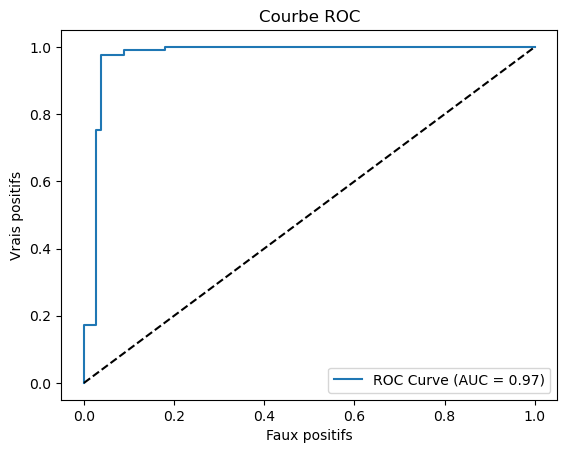

In [12]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

## 7) Interprétation des coefficients TF-IDF

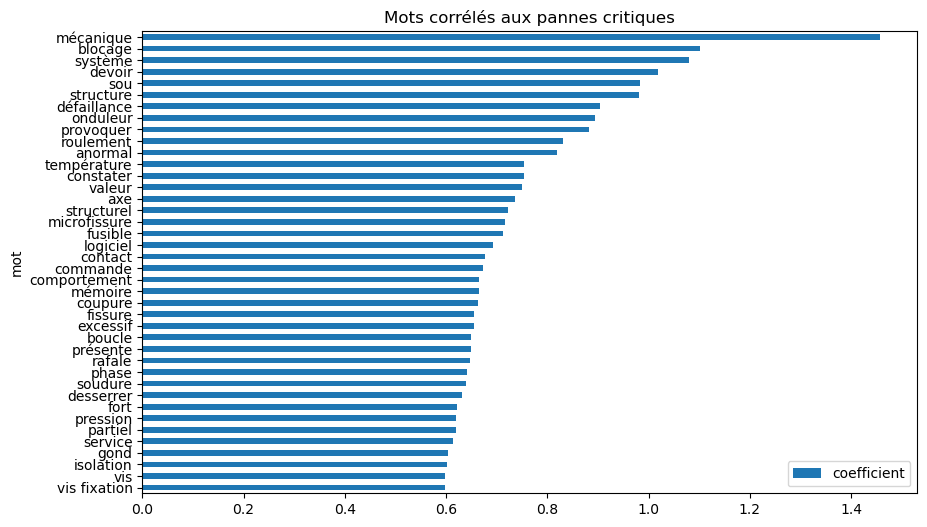

In [13]:
coeffs = model.coef_[0]
features = vectorizer.get_feature_names_out()

coeff_df = pd.DataFrame({
    "mot": features,
    "coefficient": coeffs
}).sort_values(by="coefficient", ascending=False)

# Top mots les plus prédictifs pour une panne critique
coeff_df.head(40).plot(x="mot", y="coefficient", kind="barh", figsize=(10, 6), title="Mots corrélés aux pannes critiques")
plt.gca().invert_yaxis()
plt.show()

## 8) Export pour Power BI

In [14]:
# 1. Ajout des prédictions
X_all = vectorizer.transform(df["rapport_clean"])
df["proba_critique"] = model.predict_proba(X_all)[:, 1]
df["predicted_class"] = model.predict(X_all)

# 2. Export principal pour la page 1 et 2
df.to_csv("./powerbi_data/powerbi_dataset_predictions.csv", index=False, encoding="utf-8-sig")

# 3. Export des coefficients TF-IDF pour la page 3
coeff_df = pd.DataFrame({
    "mot": vectorizer.get_feature_names_out(),
    "coefficient": model.coef_[0]
})
coeff_df["abs_coefficient"] = coeff_df["coefficient"].abs()
coeff_df = coeff_df.sort_values(by="abs_coefficient", ascending=False)
coeff_df.to_csv("./powerbi_data/powerbi_explainability_coefficients.csv", index=False, encoding="utf-8-sig")

# 4. Export des performances globales du modèle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

performance = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba)
}
performance_df = pd.DataFrame([performance])
performance_df.to_csv("./powerbi_data/powerbi_model_metrics.csv", index=False, encoding="utf-8-sig")

In [15]:
import joblib

# Sauvegarde
joblib.dump(vectorizer, "./powerbi_data/tfidf_vectorizer.pkl")
joblib.dump(model, "./powerbi_data/logistic_model.pkl")

['./powerbi_data/logistic_model.pkl']